## Load the Data

In [28]:
# Task3: correlate news sentiment with stock returns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# ---------- Helpers ----------
def compute_vader_score(text, sid):
    if pd.isna(text) or str(text).strip()=="":
        return np.nan
    s = sid.polarity_scores(str(text))
    return s['compound']   # -1..1

def compute_textblob_score(text):
    if pd.isna(text) or str(text).strip()=="":
        return np.nan
    return TextBlob(str(text)).sentiment.polarity  # -1..1

# ---------- Load your datasets ----------

news_df = pd.read_csv("../data/raw_analyst_ratings.csv")
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')


## Date Alignment

In [20]:
# ---------- Normalize news dates ----------
news = news_df.copy()
news['date'] = pd.to_datetime(news['date'], errors='coerce')
# Convert to date only (trading is daily)
news['date_only'] = news['date'].dt.date

## Sentiment Analysis

In [25]:
# ---------- Sentiment: VADER (preferred for short headlines) + TextBlob fallback ----------
sid = SentimentIntensityAnalyzer()
news['vader_compound'] = news['headline'].apply(lambda t: compute_vader_score(t, sid))
news['tb_polarity'] = news['headline'].apply(compute_textblob_score)

# If you want a combined score (simple average where available)
news['sentiment_score'] = news[['vader_compound','tb_polarity']].mean(axis=1)

# ---------- Aggregate daily sentiment ----------
# Option A: average sentiment per day
daily_sentiment = news.groupby('date_only')['sentiment_score'].agg(
    count='size',
    mean_sentiment='mean',
    median_sentiment='median',
    std_sentiment='std'
).reset_index().rename(columns={'date_only':'date'})

# convert 'date' to datetime for merging
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

## Analysis

AAPL: Pearson r=-0.0101, p=0.6327, n=2226
MSFT: Pearson r=-0.0014, p=0.9467, n=2226
AMZN: Pearson r=0.0030, p=0.8870, n=2226
GOOG: Pearson r=-0.0029, p=0.8902, n=2226
META: Pearson r=-0.0053, p=0.8123, n=1985
NVDA: Pearson r=0.0072, p=0.7345, n=2226


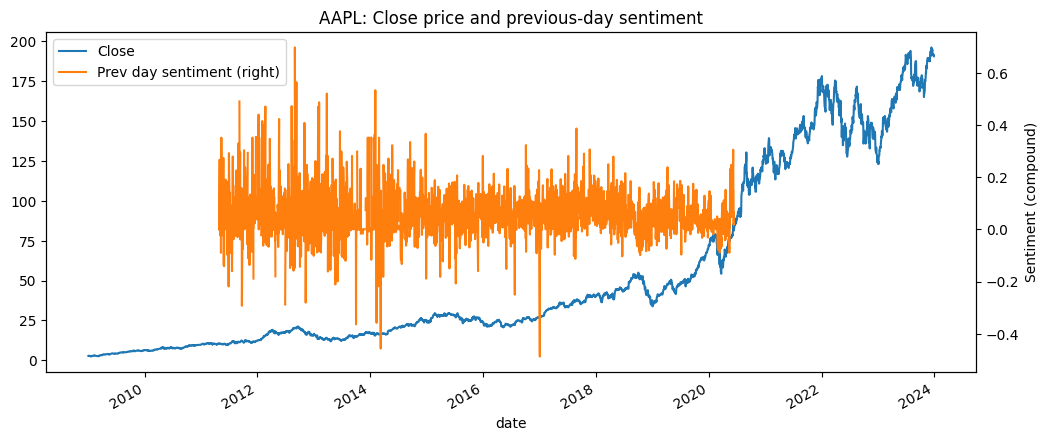

   lag         r         p     n
0    0  0.032059  0.130512  2226
1    1 -0.010136  0.632680  2226
2    2  0.024259  0.252597  2226
3    3  0.011498  0.587684  2226
4    4 -0.004186  0.843507  2226
5    5 -0.007947  0.707868  2226


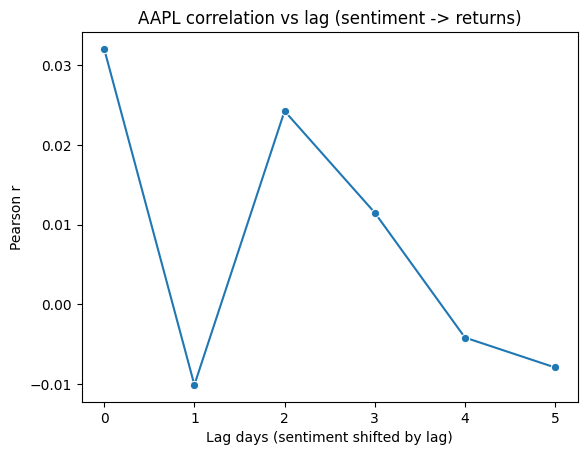

In [27]:
results = {}
for ticker, sdf in dataframes.items():
    df = sdf.copy()
    # ensure Date is datetime and has date-only column
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').dropna(subset=['Date'])
    df['date'] = df['Date'].dt.date
    # daily close and returns (pct change)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['daily_return'] = df['Close'].pct_change()
    # turn df date to datetime date for merging
    df_daily = df.groupby('date').agg(
        close=('Close','last'),
        daily_return=('daily_return','last')
    ).reset_index()
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    
    # Merge news daily sentiment with stock daily returns (inner join keeps only matched days)
    merged = pd.merge(df_daily, daily_sentiment, on='date', how='left')

    # Option: map news from non-trading days to next trading day or previous trading day
    # If many headlines happen on weekends, you may choose forward-fill the sentiment to the next trading day:
    merged = merged.sort_values('date').reset_index(drop=True)
    # forward-fill mean_sentiment to fill trading days with weekend news (if you prefer)
    merged['mean_sentiment_ffill'] = merged['mean_sentiment'].ffill()  # propagates previous non-null
    # or backward fill:
    merged['mean_sentiment_bfill'] = merged['mean_sentiment'].bfill()
    
    # choose which sentiment to correlate; typically use aggregated same-day news vs next-day return
    # Example: correlate previous-day sentiment with today's return -> shift sentiment by 1
    merged['prev_day_sentiment'] = merged['mean_sentiment'].shift(1)
    
    # drop NA rows for correlation
    corr_df = merged.dropna(subset=['prev_day_sentiment','daily_return'])
    
    # Pearson correlation and p-value
    if len(corr_df) >= 5:
        r, p = pearsonr(corr_df['prev_day_sentiment'], corr_df['daily_return'])
    else:
        r, p = (np.nan, np.nan)
    
    results[ticker] = {
        'merged': merged,
        'corr_r': r,
        'corr_p': p,
        'n': len(corr_df)
    }
    print(f"{ticker}: Pearson r={r:.4f}, p={p:.4f}, n={len(corr_df)}")

# ---------- Plot an example: AAPL sentiment vs next-day returns ----------
example = 'AAPL'
m = results[example]['merged'].copy()
plt.figure(figsize=(12,5))
ax = plt.gca()
# plot closes
m.plot(x='date', y='close', ax=ax, label='Close', color='tab:blue', secondary_y=False)
# plot prev_day_sentiment on right axis
m.plot(x='date', y='prev_day_sentiment', ax=ax, label='Prev day sentiment', color='tab:orange', secondary_y=True)
ax.set_title(f"{example}: Close price and previous-day sentiment")
ax.right_ax.set_ylabel('Sentiment (compound)')
plt.show()

# ---------- Lag scan: correlation over several lags (0..5 days) ----------
def lag_scan(merged_df, sentiment_col='mean_sentiment', ret_col='daily_return', max_lag=5):
    rows=[]
    for lag in range(0, max_lag+1):
        s = merged_df[sentiment_col].shift(lag)
        tmp = pd.concat([s, merged_df[ret_col]], axis=1).dropna()
        if len(tmp) >= 5:
            r, p = pearsonr(tmp.iloc[:,0], tmp.iloc[:,1])
        else:
            r,p = np.nan,np.nan
        rows.append({'lag':lag,'r':r,'p':p,'n':len(tmp)})
    return pd.DataFrame(rows)

scan = lag_scan(results[example]['merged'], sentiment_col='mean_sentiment', ret_col='daily_return', max_lag=5)
print(scan)
sns.lineplot(data=scan, x='lag', y='r', marker='o')
plt.title(f"{example} correlation vs lag (sentiment -> returns)")
plt.xlabel('Lag days (sentiment shifted by lag)')
plt.ylabel('Pearson r')
plt.show()
